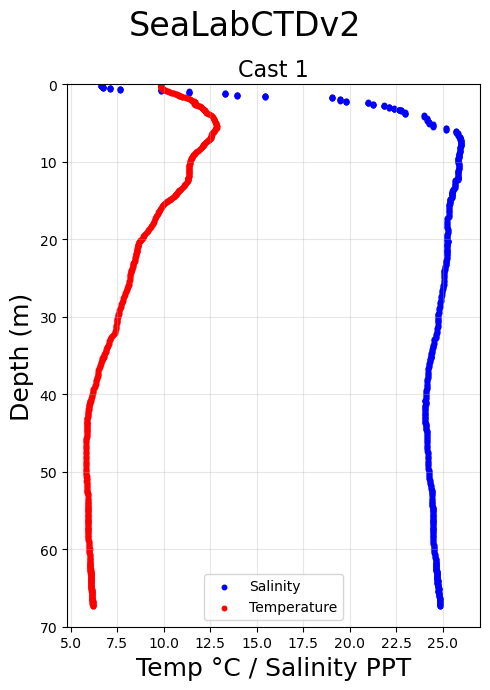

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
fname = "2025-07-10T14-22-17_clean.csv"

testName = "testNineVMT"

df = pd.read_csv(fname)

# Filter out negative depths
df = df[df["slowBRDepth"] >= 0]

# Set up the figure
fig, ax = plt.subplots(figsize=(5, 7))
fig.suptitle('SeaLabCTDv2', fontsize=24)

# Plot salinity vs depth
ax.scatter(df["sal"], df["slowBRDepth"], label="Salinity", s=5, color='blue', linewidth=2)

# Plot temperature vs depth
ax.scatter(df["fastBRTemp"], df["slowBRDepth"], label="Temperature", s=5, color='red', linewidth=2)

# Formatting
ax.set_ylim(70, 0)  # Reverse y-axis so depth increases downward
# ax.set_xlim(11., 24.5)
ax.grid(alpha=0.3)
ax.set_title("Cast 1", fontsize=16)
ax.set_xlabel("Temp °C / Salinity PPT", fontsize=18)
ax.set_ylabel("Depth (m)", fontsize=18)
ax.legend()

plt.tight_layout(rect=[0, 0, 1, 1])
# plt.show()
plt.savefig(f"{testName}_clines.jpg", dpi=600)

In [5]:
# Step 1: Convert time column to datetime (adjust format if needed)
df["time"] = pd.to_datetime(df["time"])

# Step 2: Compute time differences in seconds
time_deltas = df["time"].diff().dt.total_seconds()

# Step 3: Compute average sampling interval and frequency
avg_interval = time_deltas.mean()
sampling_frequency_hz = 1 / avg_interval

# Step 4: Compute total duration in minutes
total_duration = (df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds()
total_duration_minutes = total_duration / 60

print(f"Average sampling frequency: {sampling_frequency_hz:.2f} Hz")
print(f"Total duration: {total_duration_minutes:.2f} minutes")

# raw is 8.4min
# cast is 2.6min

# 68KB for clean file at 5hz is how many bytes a second

file_size_bytes = 68 * 1024  # 68 KB to bytes
duration_seconds = 2.6 * 60  # minutes to seconds

bytes_per_second = file_size_bytes / duration_seconds
print(f"Bytes per second: {bytes_per_second:.2f} B/s")

# Estimate time to fill a 256MB SD card
sd_card_size_bytes = 256 * 1024 * 1024  # 256 MB in bytes
time_to_fill_seconds = sd_card_size_bytes / bytes_per_second
time_to_fill_minutes = time_to_fill_seconds / 60
time_to_fill_hours = time_to_fill_minutes / 60
time_to_fill_days = time_to_fill_hours / 24

print(f"Estimated time to fill 256MB SD card:")
print(f"  {time_to_fill_seconds:.0f} seconds")
print(f"  {time_to_fill_minutes:.1f} minutes")
print(f"  {time_to_fill_hours:.2f} hours")
print(f"  {time_to_fill_days:.2f} days")

sd_card_size_bytes = 256 * 1024 * 1024  # 256 MB
bytes_per_sample = 460 / 5  # ≈ 92 B/sample
sampling_interval_seconds = 60  # 1 sample per minute

bytes_per_second = bytes_per_sample / sampling_interval_seconds  # ≈ 1.53 B/s

# Time to fill
time_to_fill_seconds = sd_card_size_bytes / bytes_per_second
time_to_fill_minutes = time_to_fill_seconds / 60
time_to_fill_hours = time_to_fill_minutes / 60
time_to_fill_days = time_to_fill_hours / 24

print(f"Estimated time to fill 256MB SD card at 1 sample/minute (~{bytes_per_second:.2f} B/s):")
print(f"  {time_to_fill_minutes:,.0f} minutes")
print(f"  {time_to_fill_hours:,.1f} hours")
print(f"  {time_to_fill_days:,.2f} days")




Average sampling frequency: 5.06 Hz
Total duration: 2.60 minutes
Bytes per second: 446.36 B/s
Estimated time to fill 256MB SD card:
  601389 seconds
  10023.2 minutes
  167.05 hours
  6.96 days
Estimated time to fill 256MB SD card at 1 sample/minute (~1.53 B/s):
  2,917,777 minutes
  48,629.6 hours
  2,026.23 days


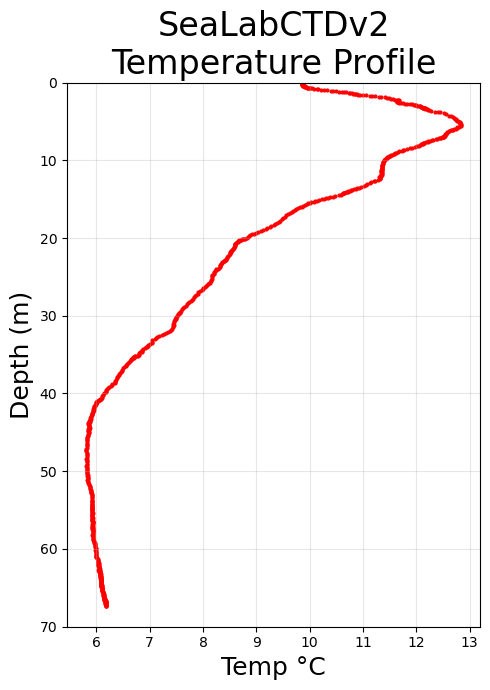

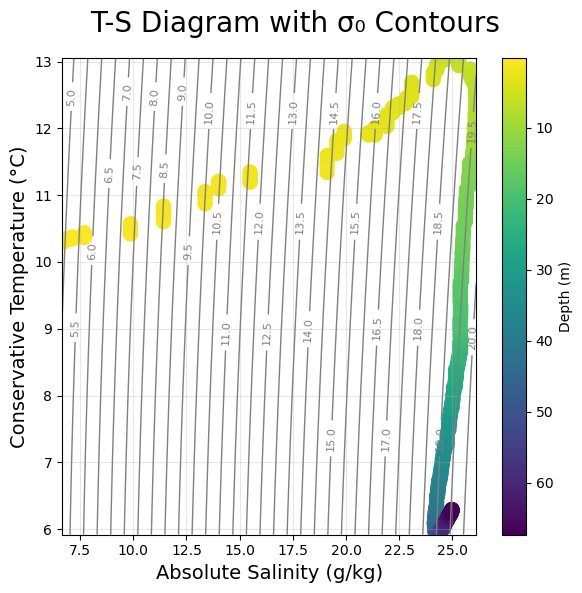

In [7]:
import gsw
import numpy as np

# Filter out negative depths
df = df[df["slowBRDepth"] >= 0]

# --- GSW Calculations ---

# Convert pressure from mbar to dbar
df["pressure"] = df["slowBRPres"] / 100

# Location (update if you know it)
latitude = 61
longitude = -150

# Calculate Absolute Salinity
df["SA"] = gsw.SA_from_SP(df["sal"], df["pressure"], longitude, latitude)

# Conservative Temperature
df["CT"] = gsw.CT_from_t(df["SA"], df["fastBRTemp"], df["pressure"])

# Potential density anomaly (sigma0)
df["sigma0"] = gsw.sigma0(df["SA"], df["CT"])

# --- Plot: Temperature & Salinity Profiles ---
fig, ax = plt.subplots(figsize=(5, 7))

ax.set_title('SeaLabCTDv2\nTemperature Profile', fontsize=24)
ax.scatter(df["fastBRTemp"], df["slowBRDepth"], s=1, color='red', linewidth=2)
ax.set_xlabel("Temp °C", fontsize=18)

# ax.set_xlim(5.5,11)
ax.set_ylim(70, 0)

ax.grid(alpha=0.3)

# ax.set_xlabel("Temp °C / Salinity g/kg", fontsize=18)

ax.set_ylabel("Depth (m)", fontsize=18)
# ax.legend()

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(f"{testName}_profile_temp.jpg", dpi=600)
# plt.savefig("testThreeVMT_profile2_salt.jpg", dpi=600)

################# --- Plot: T-S Diagram --- ########################################################
fig2, ax2 = plt.subplots(figsize=(6, 6))
fig2.suptitle("T-S Diagram with σ₀ Contours", fontsize=20)

# Scatter plot of CT vs SA with reversed colormap (deep = dark)
sc = ax2.scatter(df["SA"], df["CT"], c=df["slowBRDepth"], cmap="viridis_r", s=100, label="Data")

# Add colorbar (natural order: surface at top, deep at bottom)
cbar = fig2.colorbar(sc, ax=ax2, label="Depth (m)")
cbar.ax.invert_yaxis()

# Overlay sigma0 contours
SA_grid = np.linspace(df["SA"].min(), df["SA"].max(), 100)
CT_grid = np.linspace(df["CT"].min(), df["CT"].max(), 100)
SA_mesh, CT_mesh = np.meshgrid(SA_grid, CT_grid)
sigma0_mesh = gsw.sigma0(SA_mesh, CT_mesh)

levels = np.arange(np.floor(sigma0_mesh.min()), np.ceil(sigma0_mesh.max()) + 0.5, 0.5)
contours = ax2.contour(SA_mesh, CT_mesh, sigma0_mesh, levels=levels, colors='gray', linewidths=1)
ax2.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

ax2.set_xlabel("Absolute Salinity (g/kg)", fontsize=14)
ax2.set_ylabel("Conservative Temperature (°C)", fontsize=14)
ax2.grid(alpha=0.3)
# ax2.set_title("T-S Diagram (CT vs SA)", fontsize=16)
# ax2.set_xlim(10.5, 24.5)
# ax2.set_ylim(5.5, 11.5)

plt.tight_layout()
plt.savefig(f"{testName}_TS_diagram.jpg", dpi=600)
# plt.show()

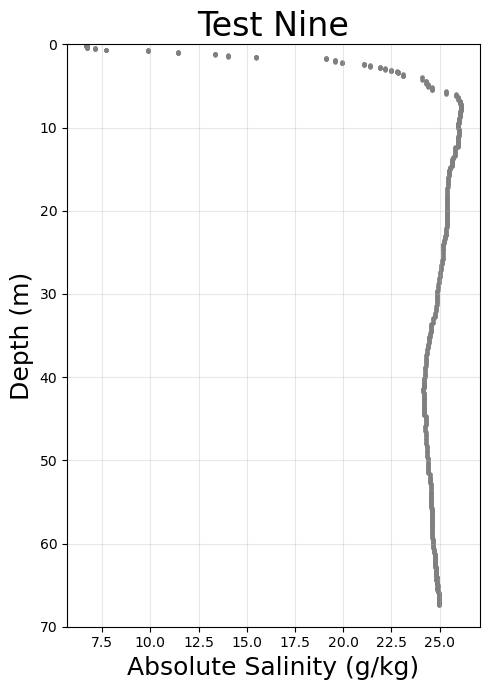

In [8]:
# Filter out negative depths
df = df[df["slowBRDepth"] >= 0]

# --- GSW Calculations ---

# Convert pressure from mbar to dbar
df["pressure"] = df["slowBRPres"] / 100

# Location (update if you know it)
latitude = 61
longitude = -146

# Calculate Absolute Salinity
df["SA"] = gsw.SA_from_SP(df["sal"], df["pressure"], longitude, latitude)

# Conservative Temperature
df["CT"] = gsw.CT_from_t(df["SA"], df["fastBRTemp"], df["pressure"])

# Potential density anomaly (sigma0)
df["sigma0"] = gsw.sigma0(df["SA"], df["CT"])

# --- Plot: Temperature & Salinity Profiles ---
fig, ax = plt.subplots(figsize=(5, 7))

# ax.set_xlim(21.5, 23.5)

ax.set_title('Test Nine', fontsize=24)
ax.scatter(df["SA"], (df["slowBRDepth"]), s=5, color='gray', linewidth=1)
# ax.scatter(df["sal"], (df["slowBRDepth"]), s=1, color='black', linewidth=2)
ax.set_xlabel("Absolute Salinity (g/kg)", fontsize=18)

ax.set_ylim(70, 0)
ax.grid(alpha=0.3)
ax.set_ylabel("Depth (m)", fontsize=18)
# ax.legend()

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(f"{testName}_profile_salt_full_depth.jpg", dpi=600)

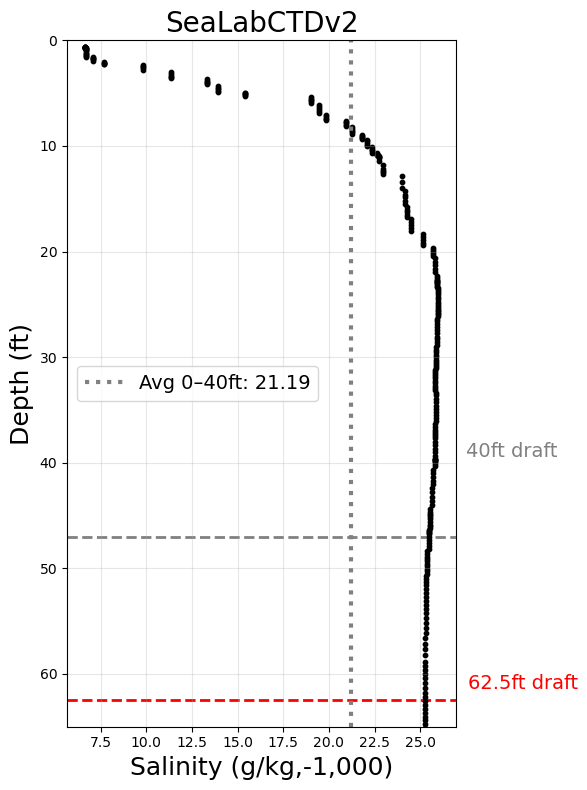

In [10]:
latitude = 61
longitude = -146.4

df = df[df["slowBRDepth"] >= 0]
df["depthFeet"] = df["slowBRDepth"] * 3.28084

df["pressure"] = df["slowBRPres"] / 100

# Calculate Absolute Salinity
df["SA"] = gsw.SA_from_SP(df["sal"], df["pressure"], longitude, latitude)

# Conservative Temperature
df["CT"] = gsw.CT_from_t(df["SA"], df["fastBRTemp"], df["pressure"])

# Potential density anomaly (sigma0)
df["sigma0"] = gsw.sigma0(df["SA"], df["CT"])

# --- Plot: Temperature & Salinity Profiles ---
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_title('SeaLabCTDv2', fontsize=20)
ax.scatter(df["sal"], df["depthFeet"], s=10, color='black',zorder=1)
ax.set_xlabel("Salinity (g/kg,-1,000)", fontsize=18)
# ax.set_xlim(26.5, 28.5)

# ax.set_ylim(44, 0) # meters
# ax.set_ylabel("Depth (m)", fontsize=18)

ax.set_ylabel("Depth (ft)", fontsize=18)
ax.set_ylim(65,0)
ax.grid(alpha=0.3)

draft = 47 #feet

# Add horizontal lines at 30 ft and 62.5 ft
ax.axhline(draft, color='gray', linestyle='--', linewidth=2,zorder=0)
ax.axhline(62.5, color='red', linestyle='--', linewidth=2,zorder=0)

# Filter for depths 
subset_33 = df[(df["depthFeet"] >= 0) & (df["depthFeet"] <= draft)]
# subset_62 = df[(df["depthFeet"] >= 0) & (df["depthFeet"] <= 62.5)]

# Compute average Absolute Salinity
avg_salinity_33 = subset_33["sal"].mean()
# avg_salinity_62 = subset_62["SA"].mean()

# Plot vertical line at average salinity
ax.axvline(avg_salinity_33, color='gray', linestyle=':', linewidth=3, label=f'Avg 0–40ft: {avg_salinity_33:.2f}')

# ax.axvline(avg_salinity_62, color='red', linestyle=':', linewidth=3, label=f'Avg 0–62.5ft: {avg_salinity_62:.2f}')

# Text label just above 30 ft
ax.text(27.5, 38, "40ft draft", color='gray', fontsize=14, ha='left', va='top')

# Text label just above 62.5 ft
ax.text(27.6, 60, "62.5ft draft", color='red', fontsize=14, ha='left', va='top')

ax.legend(fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(f"{testName}_profile_salt_AKL_plot.jpg", dpi=600)